# CADERNO DE ANÁLISE EXPLORATÓRIA - MÓDULO 2

## AULA 1 - FONTES EXTERNAS, MANIPULAÇÕES E LIMPEZA DE DADOS

### AULA 1, VIDEO 1

O bloco de código abaixo foi escrito para retornar ao ponto de paramos na última aula do módulo 1.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = pd.read_csv("https://raw.githubusercontent.com/alura-cursos/agendamento-hospitalar/main/dados/A160324189_28_143_208.csv",
                 encoding = "ISO-8859-1", skiprows = 3, sep=";", skipfooter=12, thousands = ".", decimal = ",",
                 engine="python")

colunas_usaveis = df.mean().index.tolist()
colunas_usaveis.insert(0, "Unidade da Federação")

usaveis = df[colunas_usaveis]
usaveis = usaveis.set_index("Unidade da Federação")
UFS = usaveis.index.tolist()
codigos = [uf[0:2] for uf in UFS]
regioes = []

for i in range(len(codigos)):
    if codigos[i][0] == '1':
        regioes.append("Norte")
    if codigos[i][0] == '2':
        regioes.append("Nordeste")
    if codigos[i][0] == '3':
        regioes.append("Sudeste")
    if codigos[i][0] == '4':
        regioes.append("Sul")
    if codigos[i][0] == '5':
        regioes.append("Centro-Oeste")
usaveis.insert(loc=0, column="Região", value=regioes)

usaveis_ord_total = usaveis.sort_values("Total", ascending = False)
usaveis_ord_total = usaveis_ord_total.drop("Total", axis = 1)
usaveis =  usaveis.drop("Total", axis = 1)

pd.options.display.float_format = "{:.2f}".format

ultimo_mes_valido = usaveis_ord_total[usaveis_ord_total.columns[-2]]

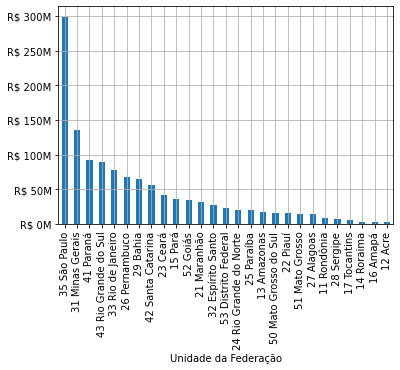

In [2]:
def millions(x, pos):
    return f'R$ {int(x/1000000)}M'

ultimo_mes_valido = ultimo_mes_valido.sort_values(ascending = False)

ax = ultimo_mes_valido.plot(kind='bar')

formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)

plt.grid()
plt.show()

Como verificado na aula passada, valores absolutos eliminam a possibilidade de observar a relatividade dos dados. São Paulo tem o maior número de habitantes entre os estados brasileiros e o maior gasto com o SUS, mas será que é o que mais gasta per capita?

Vamos identificar qual é participação de cada UF no gasto total no último mês:

In [3]:
ultimo_mes_valido/ultimo_mes_valido.sum()

Unidade da Federação
35 São Paulo             0.24
31 Minas Gerais          0.11
41 Paraná                0.08
43 Rio Grande do Sul     0.07
33 Rio de Janeiro        0.06
26 Pernambuco            0.06
29 Bahia                 0.05
42 Santa Catarina        0.05
23 Ceará                 0.03
15 Pará                  0.03
52 Goiás                 0.03
21 Maranhão              0.03
32 Espírito Santo        0.02
53 Distrito Federal      0.02
24 Rio Grande do Norte   0.02
25 Paraíba               0.02
13 Amazonas              0.01
50 Mato Grosso do Sul    0.01
22 Piauí                 0.01
51 Mato Grosso           0.01
27 Alagoas               0.01
11 Rondônia              0.01
28 Sergipe               0.01
17 Tocantins             0.00
14 Roraima               0.00
16 Amapá                 0.00
12 Acre                  0.00
Name: 2020/Jun, dtype: float64

<AxesSubplot:xlabel='Unidade da Federação'>

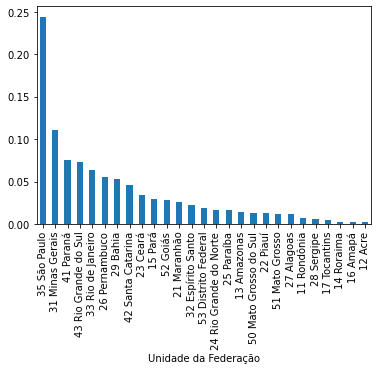

In [4]:
gastos_proporcionais = ultimo_mes_valido/ultimo_mes_valido.sum()
gastos_proporcionais.plot(kind='bar')

Devemos sempre pensar em formas de relativizar os dados... cidades e estados com maior número de pessoas idosas terão mais gasto com saúde que estados "jovens", épocas do ano - como nas festas do final - que acabam gerando mais gasto, etc. 

Vamos utilizar a base de dados sobre a população estimada pelo IBGE para poder aprofundar as análises.

In [5]:
# Fonte:  IBGE, IBGE (27 de agosto de 2020). «Estimativa Populacional 2020». ibge.gov.br. Consultado em 27 de novembro de 2020

ibge_est = pd.read_excel("https://github.com/alura-cursos/agendamento-hospitalar/raw/main/dados/estimativa_dou_2020.xls",
                         skiprows = 1, index_col = "BRASIL E UNIDADES DA FEDERAÇÃO", skipfooter=7)

ibge_est.pop("Unnamed: 1")
ibge_est

,POPULAÇÃO ESTIMADA
BRASIL E UNIDADES DA FEDERAÇÃO,
Brasil,211755692
Região Norte,18672591
Rondônia,1796460
Acre,894470
Amazonas,4207714
Roraima,631181
Pará,8690745
Amapá,861773
Tocantins,1590248


In [6]:
ibge_est.dtypes


POPULAÇÃO ESTIMADA    object
dtype: object

É possível verificar que alguns dados da coluna "população estimada" estão como string... para resolver isso, vamos remover os itens entre parenteses e normalizar os números (alguns possuem pontos para milhar e outros não)

In [7]:
# transformar todos os dados em string para não criar NaNs ao usar o str.replace
ibge_est['POPULAÇÃO ESTIMADA'] = ibge_est['POPULAÇÃO ESTIMADA'].apply(lambda x: str(x))

# utilizar regex para remover números entre parenteses
ibge_est['POPULAÇÃO ESTIMADA'] = ibge_est['POPULAÇÃO ESTIMADA'].str.replace("\(.\)","", regex=True)

# utilizar regex para remover pontos de milhar
ibge_est['POPULAÇÃO ESTIMADA'] = ibge_est['POPULAÇÃO ESTIMADA'].str.replace("\.","", regex=True)

# transformar de volta pra int
ibge_est['POPULAÇÃO ESTIMADA'] = ibge_est['POPULAÇÃO ESTIMADA'].apply(lambda x: int(x))

ibge_est

,POPULAÇÃO ESTIMADA
BRASIL E UNIDADES DA FEDERAÇÃO,
Brasil,211755692
Região Norte,18672591
Rondônia,1796460
Acre,894470
Amazonas,4207714
Roraima,631181
Pará,8690745
Amapá,861773
Tocantins,1590248


In [8]:
ibge_est.dtypes

POPULAÇÃO ESTIMADA    int64
dtype: object

#### Desafio 01 - Entre nos dados do wikipedia e leia a Base de dados direto do wikipedia.

In [9]:
pagina = "https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o"

list_dfs_wiki = pd.read_html(pagina, attrs = {"class":"wikitable sortable"})

print(f"Foram importadas {len(list_dfs_wiki)} tables da Wikipedia")

Foram importadas 2 tables da Wikipedia


In [10]:
df_pop_regiao = list_dfs_wiki[1]
list_dfs_wiki[1]

,Posição,Região,População,% da pop. total,País comparável (habitantes)
0,1,Região Sudeste,89 012 240,"42,04%",República Democrática do Congo (86 790 567)
1,2,Região Nordeste,57 374 243,"27,09%",África do Sul (58 775 022)
2,3,Região Sul,30 192 315,"14,26%",Nepal (29 609 623)
3,4,Região Norte,18 672 591,"8,82%",Cazaquistão (18 574 680)
4,5,Região Centro-Oeste,16 504 303,"7,79%",Senegal (16 209 125)


In [11]:
df_pop_uf = list_dfs_wiki[0]
list_dfs_wiki[0]

,Posição,Unidade federativa,População,% da pop. total,País comparável (habitantes)
0,1,São Paulo,46 289 333,"21,9%",Espanha (46 439 864)
1,2,Minas Gerais,21 292 666,"10,1%",Sri Lanka (20 675 000)
2,3,Rio de Janeiro,17 366 189,"8,2%",Países Baixos (16 922 900)
3,4,Bahia,14 930 634,"7,1%",Chade (14 037 000)
4,5,Paraná,11 516 840,"5,4%",Bolívia (11 410 651)
5,6,Rio Grande do Sul,11 422 973,"5,4%",Bélgica (11 250 659)
6,7,Pernambuco,9 616 621,"4,5%",Bielorrússia (9 485 300)
7,8,Ceará,9 187 103,"4,3%",Emirados Árabes Unidos (9 157 000)
8,9,Pará,8 690 745,"4,1%",Áustria (8 602 112)
9,10,Santa Catarina,7 252 502,"3,4%",Sérvia (7 114 393)


#### Desafio 02 - Neste desafio temos uma série de passos:


 * Padronizar os nomes das colunas
 * Transformar os dados nos tipos corretos
 * Transformar a UF em index

In [12]:
# Padronizando o nome das colunas

df_pop_uf.columns

Index(['Posição', 'Unidade federativa', 'População', '% da pop. total',
       'País comparável (habitantes)'],
      dtype='object')

In [13]:
df_pop_uf = df_pop_uf.rename(columns={'Posição':'index', 'Unidade federativa':'uf', 'População':"populacao",
                                      '% da pop. total':'part_pop_total','País comparável (habitantes)':'pais_approx_pop'})

df_pop_uf.head()

,index,uf,populacao,part_pop_total,pais_approx_pop
0,1,São Paulo,46 289 333,"21,9%",Espanha (46 439 864)
1,2,Minas Gerais,21 292 666,"10,1%",Sri Lanka (20 675 000)
2,3,Rio de Janeiro,17 366 189,"8,2%",Países Baixos (16 922 900)
3,4,Bahia,14 930 634,"7,1%",Chade (14 037 000)
4,5,Paraná,11 516 840,"5,4%",Bolívia (11 410 651)


In [14]:
# Transformando os dados nos tipos corretos

df_pop_uf.dtypes

index               int64
uf                 object
populacao          object
part_pop_total     object
pais_approx_pop    object
dtype: object

In [15]:
# Retirando os espaços na coluna população e trocando as vírgulas por pontos na part_pop_total
df_pop_uf.populacao = df_pop_uf.populacao.replace(" ", "", regex=True)
df_pop_uf.part_pop_total = df_pop_uf.part_pop_total.replace(",", ".", regex=True)

# Transformando a pop em int e a part_pop_total em float
df_pop_uf.part_pop_total = df_pop_uf.part_pop_total.apply(lambda x: float(x[:-1])/100)
df_pop_uf.populacao = df_pop_uf.populacao.apply(lambda x: int(x))

In [16]:
df_pop_uf.head(10)

,index,uf,populacao,part_pop_total,pais_approx_pop
0,1,São Paulo,46289333,0.22,Espanha (46 439 864)
1,2,Minas Gerais,21292666,0.10,Sri Lanka (20 675 000)
2,3,Rio de Janeiro,17366189,0.08,Países Baixos (16 922 900)
3,4,Bahia,14930634,0.07,Chade (14 037 000)
4,5,Paraná,11516840,0.05,Bolívia (11 410 651)
5,6,Rio Grande do Sul,11422973,0.05,Bélgica (11 250 659)
6,7,Pernambuco,9616621,0.04,Bielorrússia (9 485 300)
7,8,Ceará,9187103,0.04,Emirados Árabes Unidos (9 157 000)
8,9,Pará,8690745,0.04,Áustria (8 602 112)
9,10,Santa Catarina,7252502,0.03,Sérvia (7 114 393)


In [17]:
# Transformando a UF em index
df_pop_uf = df_pop_uf.set_index('uf')

In [18]:
df_pop_uf.pop('index')
df_pop_uf.pop('pais_approx_pop')
df_pop_uf.head(10)

,populacao,part_pop_total
uf,,
São Paulo,46289333,0.22
Minas Gerais,21292666,0.10
Rio de Janeiro,17366189,0.08
Bahia,14930634,0.07
Paraná,11516840,0.05
Rio Grande do Sul,11422973,0.05
Pernambuco,9616621,0.04
Ceará,9187103,0.04
Pará,8690745,0.04


### AULA 1, VIDEO 2

Agora, está na hora de juntarmos os dois dataframes: a população de cada UF junto com os gastos do SUS no último mês.

In [19]:
ultimo_mes_valido.head(10)

Unidade da Federação
35 São Paulo           299060851.62
31 Minas Gerais        135977571.87
41 Paraná               92901461.36
43 Rio Grande do Sul    89019478.82
33 Rio de Janeiro       77604925.21
26 Pernambuco           68145110.59
29 Bahia                65159300.63
42 Santa Catarina       56503747.99
23 Ceará                42146555.81
15 Pará                 35396030.78
Name: 2020/Jun, dtype: float64

In [20]:
# Normalizando os nomes dos estados no index

ultimo_mes_valido = ultimo_mes_valido.to_frame()
ultimo_mes_valido['uf'] = [uf_name[3:] for uf_name in (ultimo_mes_valido.index.tolist())]
ultimo_mes_valido = ultimo_mes_valido.set_index('uf')

In [21]:
# Unindo os dois dataframes

gastos_e_pop_recente = df_pop_uf.join(ultimo_mes_valido)
gastos_e_pop_recente.drop("part_pop_total", axis = 1, inplace = True)

Válido notar que durante a aula, o join do professor não funcionou. Por mais que as bases de dados fossem as mesmas, a forma de obtenção delas foi diferente e causou uma mudança no nome dos índices.
Para resolver, ele utilizou o str.strip() para eliminar os espaços no index do dataframe da população.

#### Desafio 03 - Buscar na documentação alguns métodos envolvendo strings

#### Desafio 04 - Desenvolver uma função para a limpeza e tratamento dos dados, retornando duas tabelas "população" e "unida".

In [22]:
def df_cl_join(df_pop, df_gastos):
    
    '''essa funcao normaliza a base de dados tirada da wikipedia, 
    une ela a base de dados dos gastos do sus e retorna ambos dfs'''
    
    populacao = (df_pop[['Unidade federativa', 'População']]).rename(columns = {'Unidade federativa': 'uf',
                                                                             'População': 'populacao'}).set_index('uf')
    unida = populacao.join(df_gastos)
    
    return populacao, unida
    

## AULA 2 - VISUALIZAÇÃO, SEABORN E PROPORCIONALIDADES

### AULA 2, VIDEO 1

In [23]:
gastos_e_pop_recente.head()

,populacao,2020/Jun
uf,,
São Paulo,46289333,299060851.62
Minas Gerais,21292666,135977571.87
Rio de Janeiro,17366189,77604925.21
Bahia,14930634,65159300.63
Paraná,11516840,92901461.36


<AxesSubplot:xlabel='uf'>

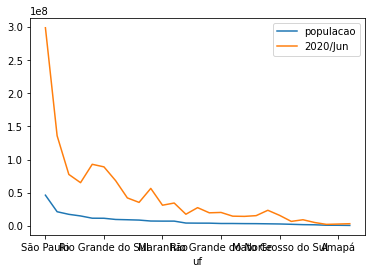

In [24]:
gastos_e_pop_recente.plot()

Esse gráfico é bem inválido... 
A forma que o plot foi feito não apresenta insight algum, são duas váriaveis não dependentes no mesmo eixo, além de ser um gráfico de linha para diferentes estados no eixo X.

O gráfico faz parecer que São Paulo gasta muito mais per capita que o Rio Grande do Sul e já vimos em outras aulas que isso não é verdade. 
Vamos criar agora também a coluna de gastos por habitante de cada estado.

In [25]:
gastos_e_pop_recente['gastos_por_habitante'] = gastos_e_pop_recente['2020/Jun'] / gastos_e_pop_recente['populacao']
gastos_e_pop_recente.head(5)

,populacao,2020/Jun,gastos_por_habitante
uf,,,
São Paulo,46289333,299060851.62,6.46
Minas Gerais,21292666,135977571.87,6.39
Rio de Janeiro,17366189,77604925.21,4.47
Bahia,14930634,65159300.63,4.36
Paraná,11516840,92901461.36,8.07


Text(0.5, 1.0, 'Gastos por habitante (em Reais) no mês de Junho de 2020 entre os estados brasileiros')

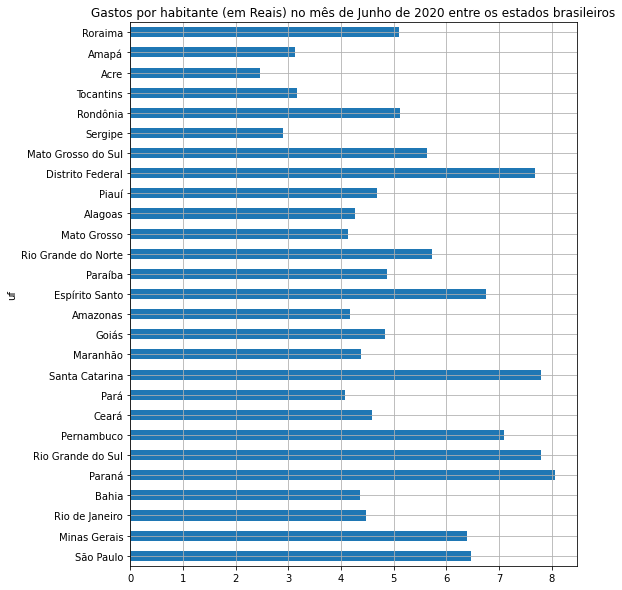

In [26]:
gastos_e_pop_recente['gastos_por_habitante'].plot(kind = 'barh', figsize = (8,10))
plt.grid()
plt.title('Gastos por habitante (em Reais) no mês de Junho de 2020 entre os estados brasileiros')

Um adendo interessante dado pelo professor: ao não ordenar as barras plotadas pelo valor per capita, temos elas ordenadas de forma crescente por gasto absoluto, o que ajuda a identificar outra história por trás do gráfico.

#### Desafio: ordenar por gasto por habitante e ordenar também por número de habitantes.

Text(0.5, 1.0, 'Gastos por habitante (em Reais) no mês de Junho de 2020 entre os estados brasileiros')

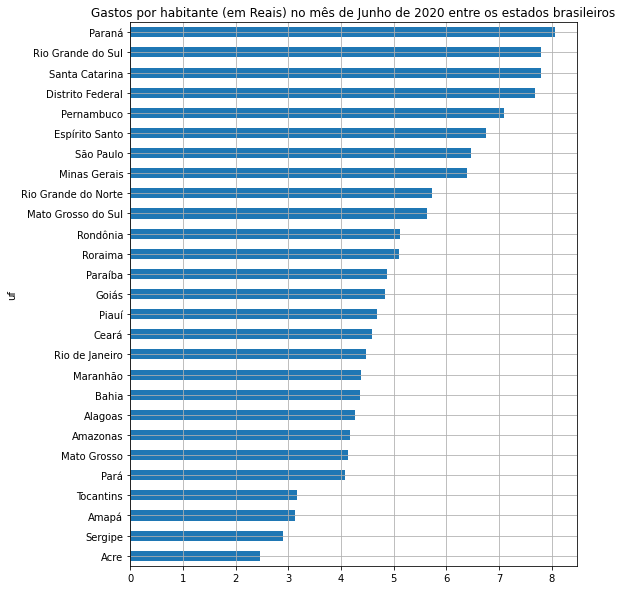

In [27]:
# Ordenando pelo gasto per capita

gastos_e_pop_recente['gastos_por_habitante'].sort_values().plot(kind = 'barh', figsize = (8,10))
plt.grid()
plt.title('Gastos por habitante (em Reais) no mês de Junho de 2020 entre os estados brasileiros')

Text(0.5, 1.0, 'Gastos por habitante (em Reais) no mês de Junho de 2020 entre os estados brasileiros')

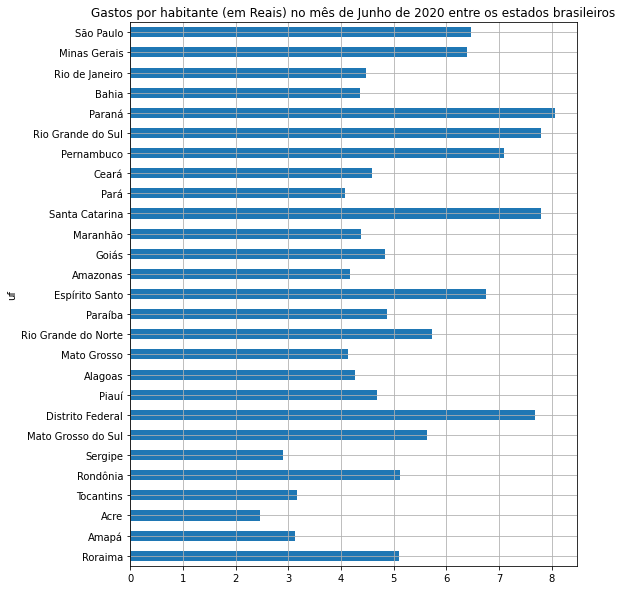

In [28]:
# Ordenando por habitantes

df_1 = gastos_e_pop_recente.sort_values(by = 'populacao')

df_1['gastos_por_habitante'].plot(kind = 'barh', figsize = (8,10))
plt.grid()
plt.title('Gastos por habitante (em Reais) no mês de Junho de 2020 entre os estados brasileiros')

Agora, vamos começar a utilizar o seaborn para visualizações.

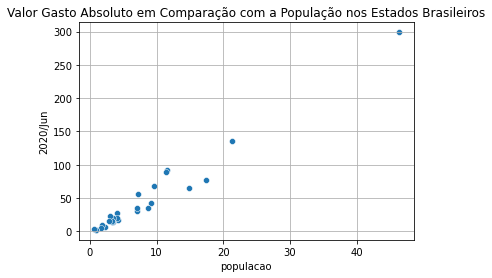

In [29]:
import seaborn as sns

sns.scatterplot(data = gastos_e_pop_recente/1000000, x = 'populacao', y = '2020/Jun')
plt.title('Valor Gasto Absoluto em Comparação com a População nos Estados Brasileiros')
plt.grid()

No gráfico acima, podemos perceber que, apesar de alguns outliers, existe uma proporcionalidade entre o gasto absoluto de cada estado e o número de habitantes. 

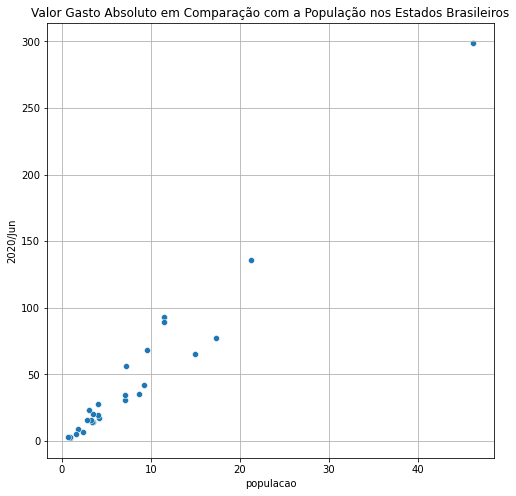

In [30]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = gastos_e_pop_recente/1000000, x = 'populacao', y = '2020/Jun')
plt.title('Valor Gasto Absoluto em Comparação com a População nos Estados Brasileiros')
plt.grid()

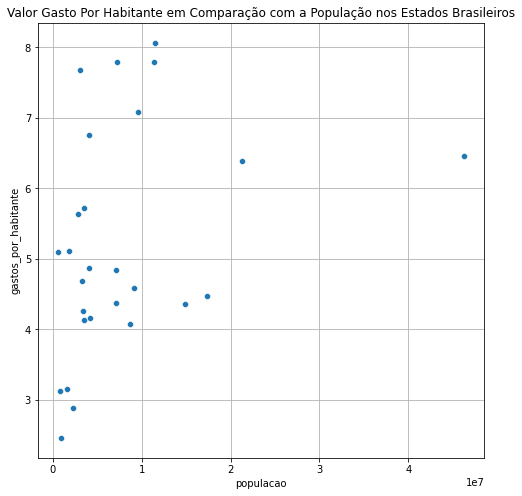

In [31]:
plt.figure(figsize = (8,8))

sns.scatterplot(data = gastos_e_pop_recente, x = 'populacao', y = 'gastos_por_habitante')
plt.title('Valor Gasto Por Habitante em Comparação com a População nos Estados Brasileiros')
plt.grid()

#### Desafio 02 (Super Desafio Gui): Fazer os mesmos gráficos do final da aulas 2.1 para meses anteriores, analisar e compartilhar suas hipóteses.

#### Desafio 03 (Super Desafio Thiago): Plotar no mesmos gráficos do final da aula o mês anterior e o mês correte, analisar e compartilhar suas hipóteses.

TO - DO
* Criar um dataframe com o mês anterior utilizando o DF inicial;
* Unir o dataframe criado com o da população;
* Pesquisar na documentação sobre 2 plots na mesma figura utilizando o Seaborn;
* Utilizar o sns e o plt para plotar os gráficos.

In [32]:
# Criar um dataframe com o mês anterior utilizando o DF inicial

df_mes_anterior = usaveis_ord_total[usaveis_ord_total.columns[-3]]

df_mes_anterior.head()

Unidade da Federação
35 São Paulo           302857660.98
31 Minas Gerais        136867275.75
41 Paraná              106103737.62
43 Rio Grande do Sul    86076113.42
33 Rio de Janeiro       86281033.16
Name: 2020/Mai, dtype: float64

In [33]:
# Retirando os números dos indexes

df_mes_anterior = df_mes_anterior.rename(lambda x: x[3:])

# Unir o dataframe criado com o da população

gastos_maio_pop = df_pop_uf.join(df_mes_anterior)

gastos_maio_pop.head(5)

,populacao,part_pop_total,2020/Mai
uf,,,
São Paulo,46289333,0.22,302857660.98
Minas Gerais,21292666,0.10,136867275.75
Rio de Janeiro,17366189,0.08,86281033.16
Bahia,14930634,0.07,61756775.71
Paraná,11516840,0.05,106103737.62


Iniciando os plots:

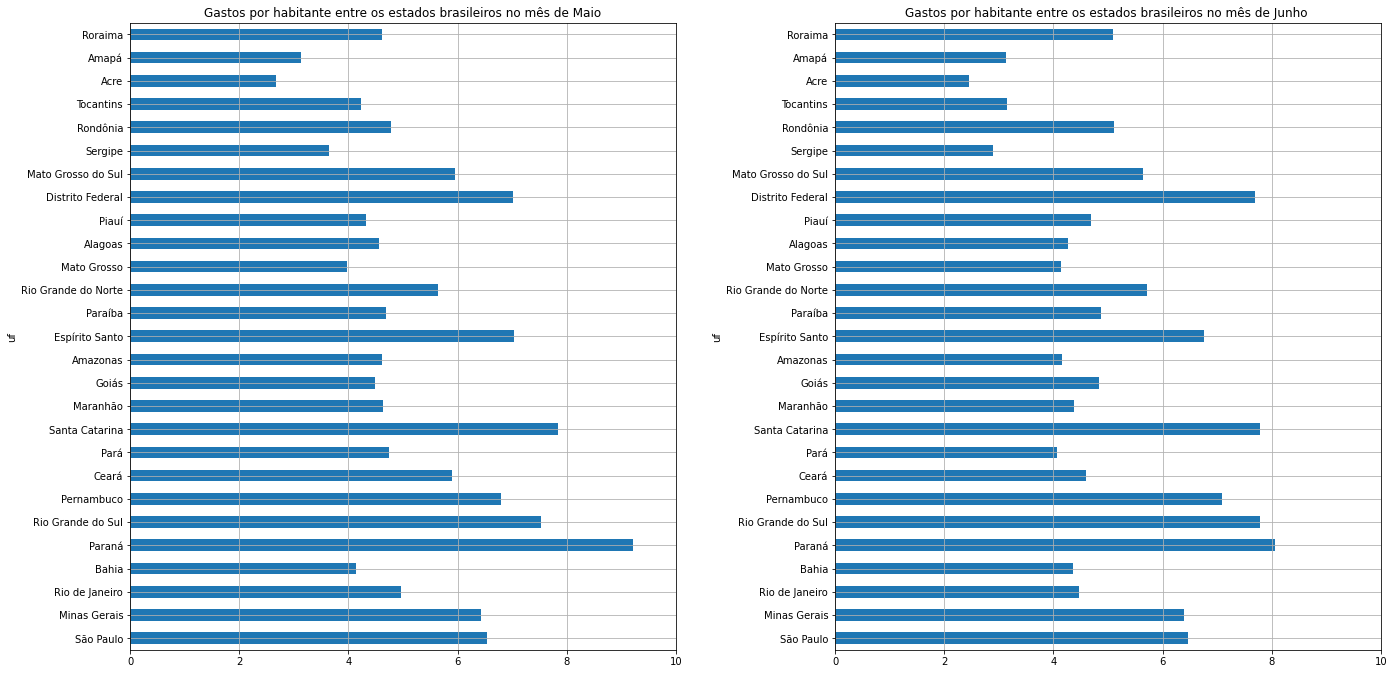

In [34]:
gastos_maio_pop['gastos_por_habitante'] = gastos_maio_pop['2020/Mai'] / gastos_maio_pop['populacao']

fig, ax = plt.subplots()

# Plot do mês de Maio

ax = plt.subplot(1,2,1)
gastos_maio_pop['gastos_por_habitante'].plot(kind = 'barh', figsize = (20,10))
ax.set_xlim(0,10)

# Customização
plt.title("Gastos por habitante entre os estados brasileiros no mês de Maio")
plt.grid()



# Plot do mês de Junho

ax = plt.subplot(1,2,2)
gastos_e_pop_recente['gastos_por_habitante'].plot(kind = 'barh', figsize = (20,10))
ax.set_xlim(0,10)

# Customização
plt.title("Gastos por habitante entre os estados brasileiros no mês de Junho ")
plt.grid()

fig.tight_layout(pad=3.0)

Podemos verificar que a diferença de gasto per capita entre os dois meses é bem baixa. Os gráficos são quase identicos, com alguns poucos estados diferindo. 

(0.05, 0.05)

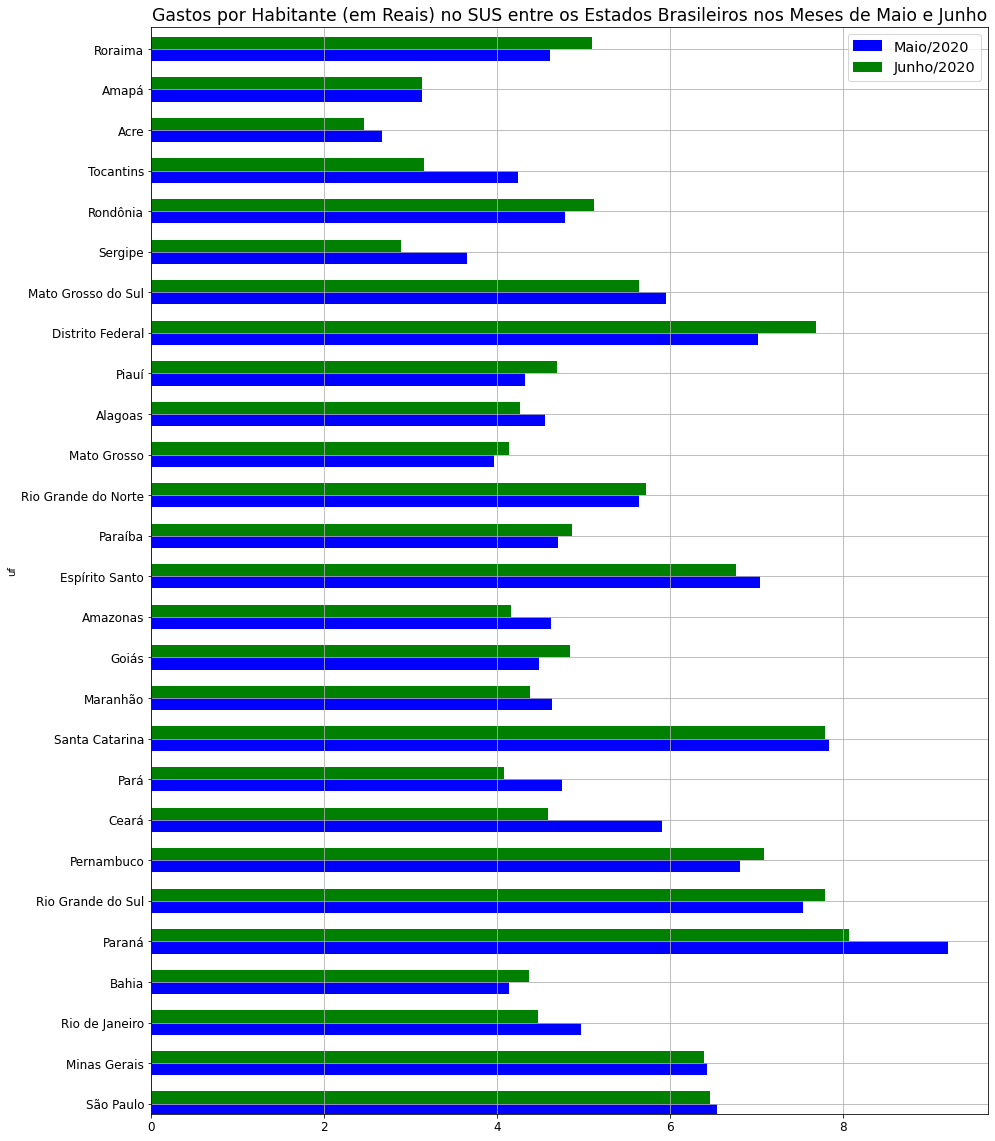

In [35]:
fig, ax = plt.subplots()

# Plots

ax = gastos_maio_pop['gastos_por_habitante'].plot(kind = 'barh',
                                                  color = 'b', figsize = (15,20), label = 'Maio/2020',
                                                  position = 1, width= 0.3, fontsize =  'large')

gastos_e_pop_recente['gastos_por_habitante'].plot(kind = 'barh',
                                                  color = 'g', figsize = (15,20), label = 'Junho/2020',
                                                  ax=ax, position = 0,  width= 0.3)


# Customização
plt.title("Gastos por Habitante (em Reais) no SUS entre os Estados Brasileiros nos Meses de Maio e Junho",
          fontsize =  'xx-large')

plt.grid()
plt.legend(fontsize =  'x-large')
plt.margins()

Para que a visualização ficasse boa e fosse possível uma comparação mais precisa, tive que utilizar uma figura maior. Como é possível verificar nesse gráfico de barras com o gasto per capita entre os meses lado-a-lado, o comportamento das barras não muda muito entre os meses diferentes, com pequenas exceções nos estados do Paraná e Ceará, que gastaram pouco mais de um real por habitante em Maio a mais que em Junho.

Agora para os plots do seaborn:

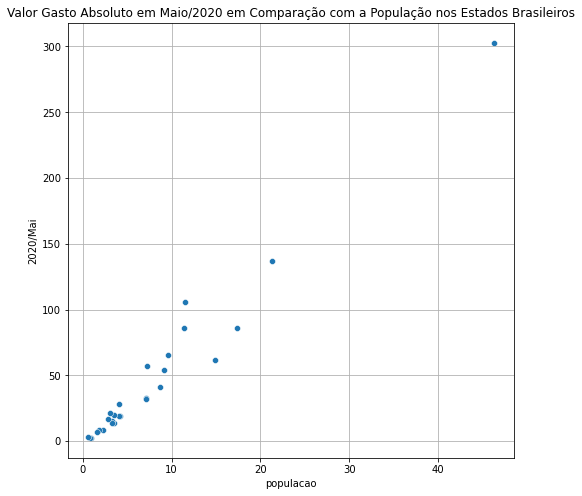

In [36]:
# Plots

plt.figure(figsize = (8,8))
sns.scatterplot(data = gastos_maio_pop/1000000, x = 'populacao', y = '2020/Mai')

# Customização


plt.title('Valor Gasto Absoluto em Maio/2020 em Comparação com a População nos Estados Brasileiros')
ax.set_xlabel('Número de Habitantes (em Milhões)')
ax.set_ylabel('Valor em Milhões de Reais')
plt.grid()

Observando o scatter plot acima, dá pra verificar o mesmo comportamento passível de previsão utilizando uma linha, comprovando a relação entre a população do estado e o gasto absoluto no SUS.

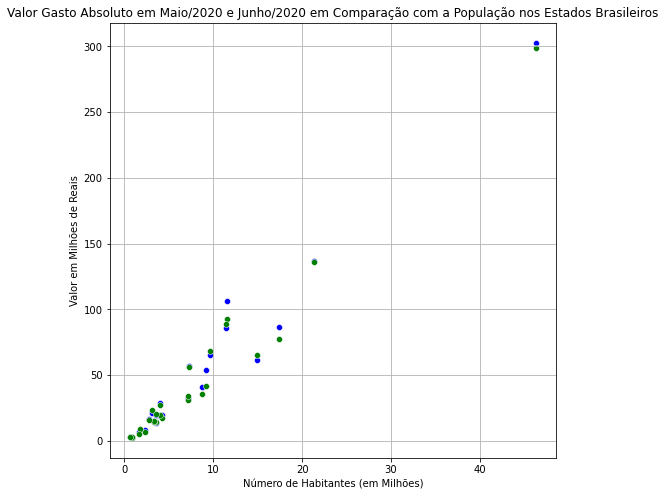

In [37]:
plt.figure(figsize = (8,8))

# Plots

ax = sns.scatterplot(data = gastos_maio_pop/1000000, x = 'populacao', y = '2020/Mai', color = 'b')
sns.scatterplot(data = gastos_e_pop_recente/1000000, x = 'populacao', y = '2020/Jun', ax = ax, color = 'g')


# Customização

plt.title('Valor Gasto Absoluto em Maio/2020 e Junho/2020 em Comparação com a População nos Estados Brasileiros')
ax.set_xlabel('Número de Habitantes (em Milhões)')
ax.set_ylabel('Valor em Milhões de Reais')
plt.grid()

Plotando agora um scatterplot com o número de habitantes no x e o gasto per capita no y.

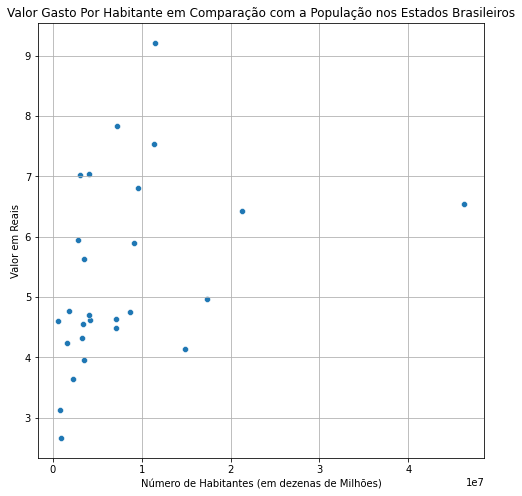

In [38]:
plt.figure(figsize = (8,8))

# Plots
ax = sns.scatterplot(data = gastos_maio_pop, x = 'populacao', y = 'gastos_por_habitante')

# Customização
ax.set_xlabel('Número de Habitantes (em dezenas de Milhões)')
ax.set_ylabel('Valor em Reais')
plt.title('Valor Gasto Por Habitante em Comparação com a População nos Estados Brasileiros')
plt.grid()

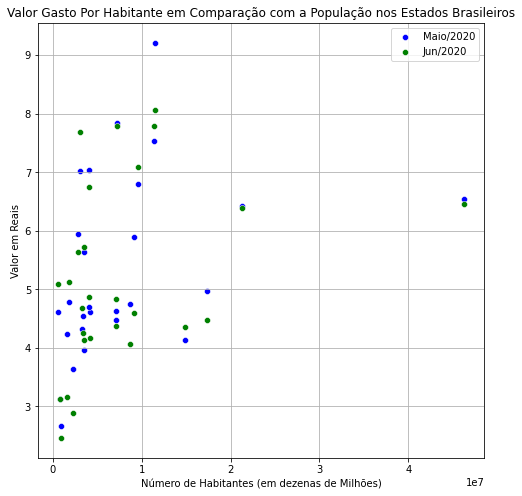

In [39]:
plt.figure(figsize = (8,8))

# Plots
ax = sns.scatterplot(data = gastos_maio_pop, x = 'populacao', y = 'gastos_por_habitante', color = 'b', label = 'Maio/2020')
sns.scatterplot(data = gastos_e_pop_recente, x = 'populacao', y = 'gastos_por_habitante', ax = ax, color = 'g', label = 'Jun/2020')

# Customização
ax.set_xlabel('Número de Habitantes (em dezenas de Milhões)')
ax.set_ylabel('Valor em Reais')
plt.legend()
plt.title('Valor Gasto Por Habitante em Comparação com a População nos Estados Brasileiros')
plt.grid()

Como é possível verificar no gráfico acima, o plot entre os dois meses não mudou muito (além das poucas exceções apresentadas mais detalhadamente nos gráficos de barras).

### AULA 2, VIDEO 2 - Resolução do Super Desafio pelos Professores

A ideia dos professores para resolver os desafios foi diferente da minha. Eles juntaram ambos os dataframes (com os valores de Junho e Julho, no caso deles) ao invés de utilizar dataframes diferentes, uma solução mais simples que a que eu achei para resolver. 

Inicialmente, eles definiram uma função para criar as colunas de gastos e gastos por habitante:

In [40]:
def gastos_e_gastos_por_habitante_para(mes : str, dados_in = usaveis_ord_total, dados_out = gastos_e_pop_recente):
    
    ''' Insere duas colunas em um dataframe: a primeira utiliza os dados do df dados_in e 
    uma string com o nome do mês escolhido para adicionar os gastos totais mensais por 
    estado ao dataframe dados_out, a segunda utiliza os dados recém adicionados para calcular o per_capita'''
    
    gastos_mes = dados_in[mes]
    gastos_mes.index = gastos_mes.index.str[3:]
    
    dados_out[f'{mes}'] = dados_in[mes]
    dados_out[f'gastos_por_habitante_{mes}'] = dados_out[mes] / dados_out['populacao']


Agora, com a função criada, podemos adicionar o mês de Maio:

In [41]:
gastos_e_gastos_por_habitante_para("2020/Mai")

In [42]:
gastos_e_pop_recente.head(5)

,populacao,2020/Jun,gastos_por_habitante,2020/Mai,gastos_por_habitante_2020/Mai
uf,,,,,
São Paulo,46289333,299060851.62,6.46,302857660.98,6.54
Minas Gerais,21292666,135977571.87,6.39,136867275.75,6.43
Rio de Janeiro,17366189,77604925.21,4.47,86281033.16,4.97
Bahia,14930634,65159300.63,4.36,61756775.71,4.14
Paraná,11516840,92901461.36,8.07,106103737.62,9.21


<AxesSubplot:xlabel='populacao', ylabel='2020/Jun'>

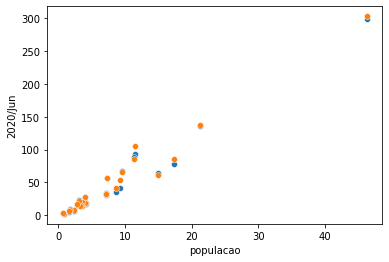

In [43]:
sns.scatterplot(data = gastos_e_pop_recente/1000000, x = 'populacao', y='2020/Jun')
sns.scatterplot(data = gastos_e_pop_recente/1000000, x = 'populacao', y='2020/Mai')

<AxesSubplot:xlabel='populacao', ylabel='2020/Jun'>

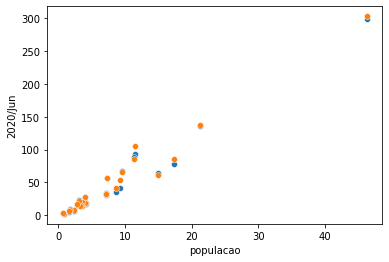

In [44]:
sns.scatterplot(data = gastos_e_pop_recente/1000000, x = 'populacao', y='2020/Jun')
sns.scatterplot(data = gastos_e_pop_recente/1000000, x = 'populacao', y='2020/Mai')

## AULA 3 - TICKS, ESCALAS E FORMATAÇÃO DAS IMAGENS

In [45]:
usaveis_ord_total.index = usaveis_ord_total.index.str[3:]
usaveis_ord_total = usaveis_ord_total.iloc[:,7:]
usaveis_ord_total.head()

,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,2008/Nov,...,2019/Out,2019/Nov,2019/Dez,2020/Jan,2020/Fev,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,
São Paulo,172834914.73,170481849.56,170278285.95,172402180.59,175416595.83,179525002.10,179898070.22,180082203.71,191685220.08,190539738.80,...,303382527.10,282391773.21,272697695.04,301991167.67,271356784.04,276606288.92,251696362.66,302857660.98,299060851.62,282709570.31
Minas Gerais,70301089.50,79119005.51,79046322.41,79268070.12,79608652.53,82200224.47,80374117.08,82400146.79,88613476.60,84486996.11,...,166133803.32,152106660.17,152398599.06,158097903.98,141323175.61,147078556.29,126330649.86,136867275.75,135977571.87,120467187.34
Paraná,48855046.46,55611791.07,56115135.82,55574831.93,56094754.74,59802402.07,56699001.13,58091985.79,61365941.22,59667208.62,...,133847978.48,126209369.22,113545318.91,122268754.10,116061602.52,114476997.52,96727112.19,106103737.62,92901461.36,80320852.69
Rio Grande do Sul,45897704.82,52928695.92,51972416.77,51679350.79,53759674.01,56391647.77,56233758.74,57910170.98,59592124.91,57565742.08,...,96913904.71,90971809.22,88720873.59,97474362.62,85451646.35,84651396.59,76294596.96,86076113.42,89019478.82,78929703.81
Rio de Janeiro,44122593.19,42892665.52,45295962.86,43951349.46,44102925.77,44348520.04,42487939.51,43066461.47,44553314.55,41351511.51,...,82247728.87,74620476.61,74895861.63,79705663.75,72412810.42,73594497.93,68160773.35,86281033.16,77604925.21,71540227.33


<AxesSubplot:ylabel='Rio Grande do Sul'>

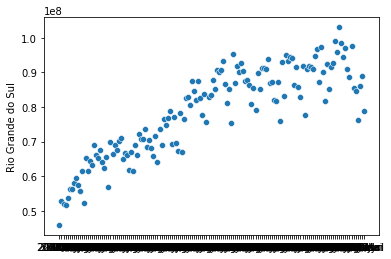

In [46]:
mensal = usaveis_ord_total.T

sns.scatterplot(data=mensal, x = mensal.index, y="Rio Grande do Sul")

#### Desafio 01: Fazer o scatter plot feito em aula para o seu estado, leia um pouco da documentação sobre este gráfico e teste alguns parâmetros.

#### Desafio 02: Formatar o eixo y colocando a escala em milhões usando o StrMethodFormatter, colocar um título e colocar o título nos 2 eixos, alterando os tamanhos dos títulos.

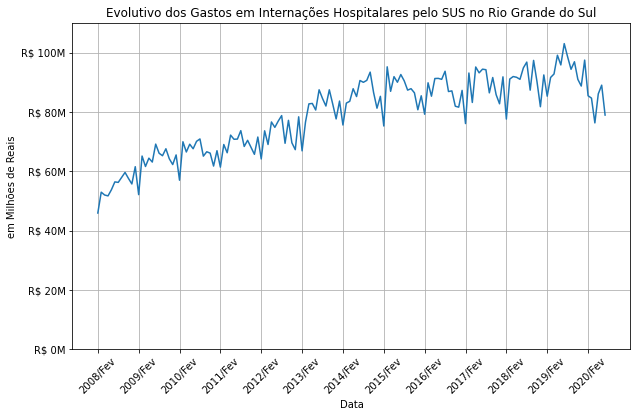

In [47]:
# Plot
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(data=mensal, x = mensal.index, y="Rio Grande do Sul")

# Customização X
plt.xticks(rotation = 45)
ax.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset = 0))

ax.set_xlabel("Data")

# Customização Y
ax.set_ylabel("em Milhões de Reais")

ax.set_ylim(0,110000000)
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)


plt.title("Evolutivo dos Gastos em Internações Hospitalares pelo SUS no Rio Grande do Sul")
plt.grid()
plt.show()

## AULA 4 - TRABALHANDO COM DATETIME E MELT

### AULA 4, VIDEO 1

Existe uma lib de python especifíca para trabalhar com datas e horários. No primeiro video da aula 4, vamos explorar um pouco a biblioteca e utiliza-la em conjunto com os dataframes anteriormente criados.

[Documentação do datetime.](https://docs.python.org/3/library/datetime.html)

In [48]:
import datetime

datetime.datetime(2020,11,3)

datetime.datetime(2020, 11, 3, 0, 0)

In [49]:
from datetime import date

Importaremos apenas o sub-módulo "date" uma vez que não trabalhamos com hora nas tabelas obtidas no datasus. Vamos aplicar o módulo no dataframe em que os Indexes são os meses.

In [50]:

meses = { 
    'Jan' : 1,
    'Fev' : 2,
    'Mar' : 3,
    'Abr' : 4,
    'Mai' : 5,
    'Jun' : 6,
    'Jul' : 7,
    'Ago' : 8,
    'Set' : 9,
    'Out' : 10,
    'Nov' : 11,
    'Dez' : 12
}

def mes_para_dia(data : str):
    ano : int = int(data[:4])
    mes : int = meses[data[5:]]    
    return date(ano, mes, 1)
    
    
    
mensal.index = mensal.index.map(mes_para_dia)

In [51]:
mensal.head(5)

Unidade da Federação,São Paulo,Minas Gerais,Paraná,Rio Grande do Sul,Rio de Janeiro,Bahia,Pernambuco,Santa Catarina,Ceará,Goiás,...,Piauí,Alagoas,Mato Grosso,Amazonas,Sergipe,Tocantins,Rondônia,Acre,Roraima,Amapá
2008-02-01,172834914.73,70301089.50,48855046.46,45897704.82,44122593.19,33410124.06,26222079.10,24409572.92,27643304.86,18149374.27,...,9711680.20,8112220.30,7929894.93,7934652.10,4636850.76,5051932.07,1940792.63,1743978.66,771687.83,1275063.72
2008-03-01,170481849.56,79119005.51,55611791.07,52928695.92,42892665.52,41301703.40,30716361.81,27483480.50,30085370.22,20992213.03,...,10428191.09,9210505.56,9416367.68,8641517.13,5017838.07,5200151.87,1955721.68,2057439.02,876091.18,1177745.93
2008-04-01,170278285.95,79046322.41,56115135.82,51972416.77,45295962.86,42826993.62,30589332.79,27806641.44,31376221.00,21049477.30,...,10227943.00,10466691.94,9390588.03,8531576.49,5265951.03,5343714.73,2143353.81,2057829.69,896952.53,1396371.51
2008-05-01,172402180.59,79268070.12,55574831.93,51679350.79,43951349.46,42071294.17,31409553.23,28354279.52,31189904.62,19162546.79,...,10562148.66,9844096.03,9378197.25,9079902.15,5367094.94,5344487.99,2280382.58,2226577.93,1027288.73,1411520.77
2008-06-01,175416595.83,79608652.53,56094754.74,53759674.01,44102925.77,39910042.40,28947510.92,28993292.76,29463965.11,20332533.92,...,10465088.93,10288668.11,9450300.60,8646295.77,4981036.36,5398413.09,2624542.97,2112576.82,938293.54,1420892.01


Nesse formato, o plot é facilitado uma vez que o matplotlib entende as datas como valores e não como strings. Perceba que no exemplo a seguir não houve necessidade de customizar os ticks no eixo X:

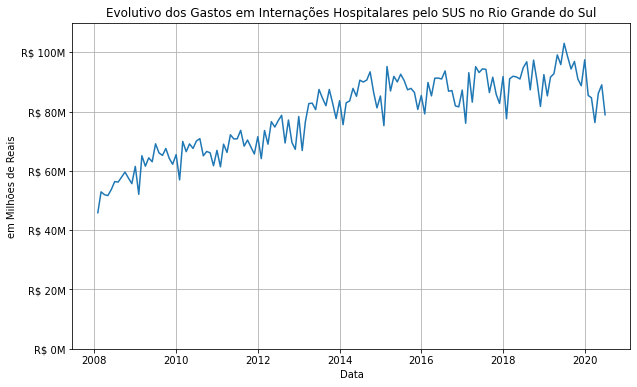

In [52]:
# Plot
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(data=mensal, x = mensal.index, y="Rio Grande do Sul")

# Customização X
# plt.xticks(rotation = 45)
# ax.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset = 0))

ax.set_xlabel("Data")

# Customização Y
ax.set_ylabel("em Milhões de Reais")

ax.set_ylim(0,110000000)
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)


plt.title("Evolutivo dos Gastos em Internações Hospitalares pelo SUS no Rio Grande do Sul")
plt.grid()
plt.show()

### AULA 4, VIDEO 2

###### Pequeno desafio - resolver os problemas que o professor apresentou no plot inicial do video 2 da quarta aula sem precisar alterar os df

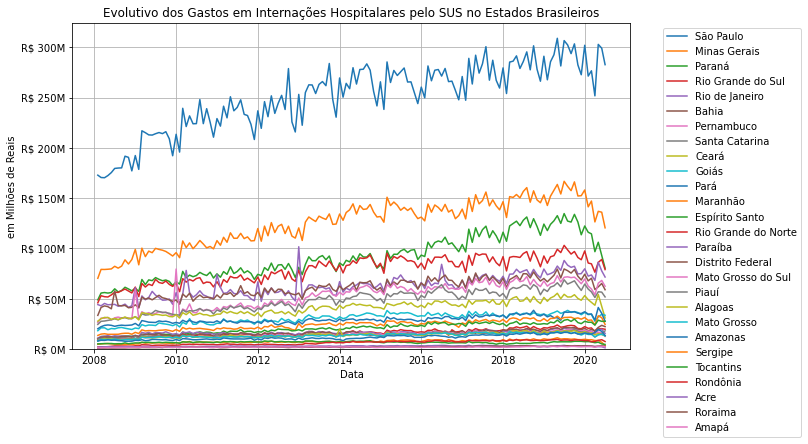

In [53]:
# Plot
fig, ax = plt.subplots(figsize = (10,6))

for uf in mensal.columns.to_list():
    ax = sns.lineplot(data=mensal, x = mensal.index, y=uf, label = uf)

# Customização X
ax.set_xlabel("Data")

# Customização Y
ax.set_ylabel("em Milhões de Reais")
ax.set_ylim(0)
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Evolutivo dos Gastos em Internações Hospitalares pelo SUS no Estados Brasileiros")
plt.grid()
plt.show()

#### Iniciando a aula

A ideia dessa aula é criar um dataframe que possui as colunas MES, VALOR GASTO e ESTADO ao inves de utilizar uma coluna por estado, usando 27 linhas iniciando com a mesma data, mas com estados e valores diferentes. 

Inicialmente, vamos resetar o indexagem do dataframe, tirando-a das datas.

In [54]:
mensal.reset_index()

Unidade da Federação,index,São Paulo,Minas Gerais,Paraná,Rio Grande do Sul,Rio de Janeiro,Bahia,Pernambuco,Santa Catarina,Ceará,...,Piauí,Alagoas,Mato Grosso,Amazonas,Sergipe,Tocantins,Rondônia,Acre,Roraima,Amapá
0,2008-02-01,172834914.73,70301089.50,48855046.46,45897704.82,44122593.19,33410124.06,26222079.10,24409572.92,27643304.86,...,9711680.20,8112220.30,7929894.93,7934652.10,4636850.76,5051932.07,1940792.63,1743978.66,771687.83,1275063.72
1,2008-03-01,170481849.56,79119005.51,55611791.07,52928695.92,42892665.52,41301703.40,30716361.81,27483480.50,30085370.22,...,10428191.09,9210505.56,9416367.68,8641517.13,5017838.07,5200151.87,1955721.68,2057439.02,876091.18,1177745.93
2,2008-04-01,170278285.95,79046322.41,56115135.82,51972416.77,45295962.86,42826993.62,30589332.79,27806641.44,31376221.00,...,10227943.00,10466691.94,9390588.03,8531576.49,5265951.03,5343714.73,2143353.81,2057829.69,896952.53,1396371.51
3,2008-05-01,172402180.59,79268070.12,55574831.93,51679350.79,43951349.46,42071294.17,31409553.23,28354279.52,31189904.62,...,10562148.66,9844096.03,9378197.25,9079902.15,5367094.94,5344487.99,2280382.58,2226577.93,1027288.73,1411520.77
4,2008-06-01,175416595.83,79608652.53,56094754.74,53759674.01,44102925.77,39910042.40,28947510.92,28993292.76,29463965.11,...,10465088.93,10288668.11,9450300.60,8646295.77,4981036.36,5398413.09,2624542.97,2112576.82,938293.54,1420892.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2020-03-01,276606288.92,147078556.29,114476997.52,84651396.59,73594497.93,70340301.29,59628674.07,56709962.09,46395356.97,...,15318975.43,15998721.86,14444207.60,14773739.41,9193248.73,7025821.12,7174312.31,2859102.06,2813954.05,2286241.46
146,2020-04-01,251696362.66,126330649.86,96727112.19,76294596.96,68160773.35,59109689.20,53843729.23,51179993.45,43468816.62,...,11878587.16,14241361.44,11943713.53,16330913.81,8395906.57,6204453.42,7423678.64,2472063.08,2304961.42,1774558.12
147,2020-05-01,302857660.98,136867275.75,106103737.62,86076113.42,86281033.16,61756775.71,65424719.40,56843604.33,54200339.48,...,14175053.45,15254204.31,13981483.29,19441150.53,8450209.57,6732370.56,8581195.13,2383895.48,2910776.44,2701014.87
148,2020-06-01,299060851.62,135977571.87,92901461.36,89019478.82,77604925.21,65159300.63,68145110.59,56503747.99,42146555.81,...,15375523.59,14278872.07,14585009.42,17509334.66,6705923.03,5018138.13,9193593.76,2199920.70,3216466.51,2699492.23


In [55]:
mensal_aberto = mensal.reset_index().melt(id_vars=['index'], value_vars = mensal.columns)
mensal_aberto.columns = ['dia_mes_ano', 'uf', 'gasto']
mensal_aberto['dia_mes_ano'] = mensal_aberto['dia_mes_ano'].astype('datetime64')
mensal_aberto

,dia_mes_ano,uf,gasto
0,2008-02-01,São Paulo,172834914.73
1,2008-03-01,São Paulo,170481849.56
2,2008-04-01,São Paulo,170278285.95
3,2008-05-01,São Paulo,172402180.59
4,2008-06-01,São Paulo,175416595.83
...,...,...,...
4045,2020-03-01,Amapá,2286241.46
4046,2020-04-01,Amapá,1774558.12
4047,2020-05-01,Amapá,2701014.87
4048,2020-06-01,Amapá,2699492.23


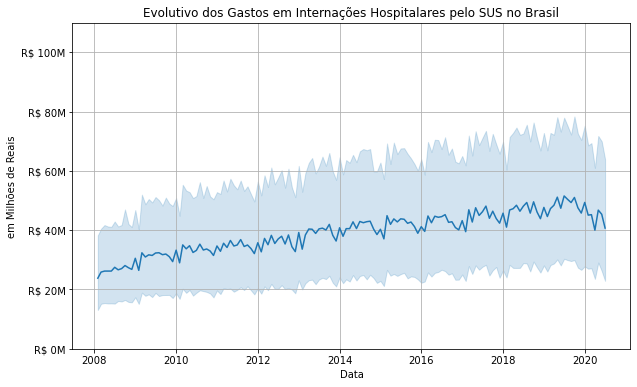

In [56]:
# Plot
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(data=mensal_aberto, x = 'dia_mes_ano', y="gasto")

# Customização X
# plt.xticks(rotation = 45)
# ax.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset = 0))

ax.set_xlabel("Data")

# Customização Y
ax.set_ylabel("em Milhões de Reais")

ax.set_ylim(0,110000000)
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)


plt.title("Evolutivo dos Gastos em Internações Hospitalares pelo SUS no Brasil")
plt.grid()
plt.show()

No plot acima, o seaborn agregou diferentes valores de y para a mesma data (diferentes estados), criando um intervalo de confiança. Na linha do meio, temos a média dos valores.

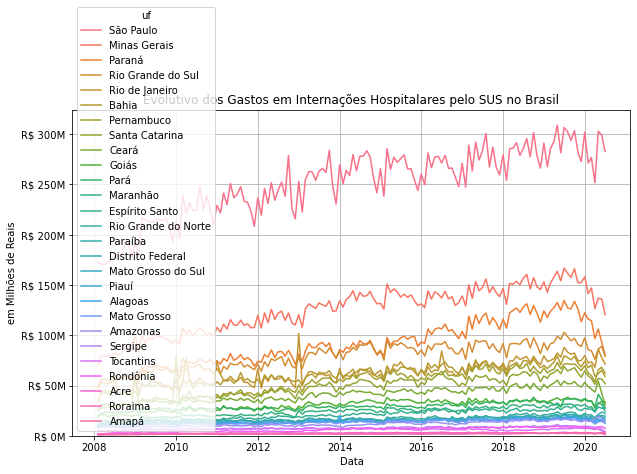

In [57]:
# Plot
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(data=mensal_aberto, x = 'dia_mes_ano', y="gasto", hue= 'uf')

# Customização X
# plt.xticks(rotation = 45)
# ax.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset = 0))

ax.set_xlabel("Data")

# Customização Y
ax.set_ylabel("em Milhões de Reais")

ax.set_ylim(0)
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)


plt.title("Evolutivo dos Gastos em Internações Hospitalares pelo SUS no Brasil")
plt.grid()
plt.show()

#### Desafio 03: Melhorar o gráfico da distribuição do gráfico:

* Escolha apenas alguns estados.
* Mude a palete de cores.
* Posicione a legenda de forma mais adequada.
* Adicione título principal e nos eixos x e y.

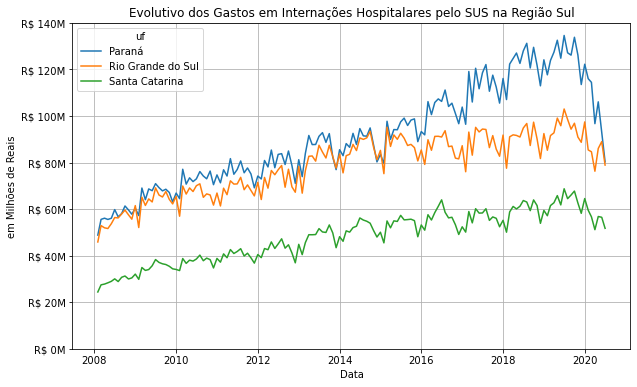

In [58]:
estados = ['Rio Grande do Sul', 'Santa Catarina', 'Paraná']

# Plot
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(data=mensal_aberto.loc[mensal_aberto['uf'].isin(estados)], x = 'dia_mes_ano', y="gasto", hue = 'uf')

# Customização X
# plt.xticks(rotation = 45)
# ax.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset = 0))

ax.set_xlabel("Data")

# Customização Y
ax.set_ylabel("em Milhões de Reais")

ax.set_ylim(0)
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)


plt.title("Evolutivo dos Gastos em Internações Hospitalares pelo SUS na Região Sul")
plt.grid()
plt.show()

#### Desafio 02: Aprendemos a usar o Melt para desnormalizar sua base de dados, agora o desafio é realizar o processo contrário, voltar atrás partindo do mensal_aberto chegando no mensal.

In [59]:
mensal_aberto.head(3)

,dia_mes_ano,uf,gasto
0,2008-02-01,São Paulo,172834914.73
1,2008-03-01,São Paulo,170481849.56
2,2008-04-01,São Paulo,170278285.95


In [60]:
mensal.head(3)

Unidade da Federação,São Paulo,Minas Gerais,Paraná,Rio Grande do Sul,Rio de Janeiro,Bahia,Pernambuco,Santa Catarina,Ceará,Goiás,...,Piauí,Alagoas,Mato Grosso,Amazonas,Sergipe,Tocantins,Rondônia,Acre,Roraima,Amapá
2008-02-01,172834914.73,70301089.50,48855046.46,45897704.82,44122593.19,33410124.06,26222079.10,24409572.92,27643304.86,18149374.27,...,9711680.20,8112220.30,7929894.93,7934652.10,4636850.76,5051932.07,1940792.63,1743978.66,771687.83,1275063.72
2008-03-01,170481849.56,79119005.51,55611791.07,52928695.92,42892665.52,41301703.40,30716361.81,27483480.50,30085370.22,20992213.03,...,10428191.09,9210505.56,9416367.68,8641517.13,5017838.07,5200151.87,1955721.68,2057439.02,876091.18,1177745.93
2008-04-01,170278285.95,79046322.41,56115135.82,51972416.77,45295962.86,42826993.62,30589332.79,27806641.44,31376221.00,21049477.30,...,10227943.00,10466691.94,9390588.03,8531576.49,5265951.03,5343714.73,2143353.81,2057829.69,896952.53,1396371.51


In [61]:
mensal_fechado = mensal_aberto.pivot(index = 'dia_mes_ano', columns = 'uf')
mensal_fechado

gasto                                                 \
uf                Acre     Alagoas      Amapá    Amazonas       Bahia   
dia_mes_ano                                                             
2008-02-01  1743978.66  8112220.30 1275063.72  7934652.10 33410124.06   
2008-03-01  2057439.02  9210505.56 1177745.93  8641517.13 41301703.40   
2008-04-01  2057829.69 10466691.94 1396371.51  8531576.49 42826993.62   
2008-05-01  2226577.93  9844096.03 1411520.77  9079902.15 42071294.17   
2008-06-01  2112576.82 10288668.11 1420892.01  8646295.77 39910042.40   
...                ...         ...        ...         ...         ...   
2020-03-01  2859102.06 15998721.86 2286241.46 14773739.41 70340301.29   
2020-04-01  2472063.08 14241361.44 1774558.12 16330913.81 59109689.20   
2020-05-01  2383895.48 15254204.31 2701014.87 19441150.53 61756775.71   
2020-06-01  2199920.70 14278872.07 2699492.23 17509334.66 65159300.63   
2020-07-01  1163813.08 13087850.40 2155083.37 13358514.02 58898100.40   

                                                                     \
uf                Ceará Distrito Federal Espírito Santo       Goiás   
dia_mes_ano                                                           
2008-02-01  27643304.86      10215956.80    10032886.43 18149374.27   
2008-03-01  30085370.22      11627918.26    12262049.08 20992213.03   
2008-04-01  31376221.00      11922015.36    12453466.98 21049477.30   
2008-05-01  31189904.62      11900817.00    11789786.09 19162546.79   
2008-06-01  29463965.11      11969271.76    11889687.35 20332533.92   
...                 ...              ...            ...         ...   
2020-03-01  46395356.97      19405446.88    26555688.68 34558308.52   
2020-04-01  43468816.62      18123899.78    23735724.64 27499307.93   
2020-05-01  54200339.48      21437430.22    28614683.75 31870107.62   
2020-06-01  42146555.81      23479773.03    27450865.16 34437633.20   
2020-07-01  30809221.22      22233542.26    27460475.47 33499284.38   

                         ...                                  \
uf             Maranhão  ...       Piauí Rio Grande do Norte   
dia_mes_ano              ...                                   
2008-02-01  13452263.93  ...  9711680.20          9110108.87   
2008-03-01  14750895.33  ... 10428191.09         10126626.54   
2008-04-01  15148647.11  ... 10227943.00         10964234.85   
2008-05-01  14543679.92  ... 10562148.66         11032871.23   
2008-06-01  14553978.06  ... 10465088.93         10450599.08   
...                 ...  ...         ...                 ...   
2020-03-01  28832662.46  ... 15318975.43         20936692.02   
2020-04-01  23938156.77  ... 11878587.16         17319947.66   
2020-05-01  32979447.97  ... 14175053.45         19916570.52   
2020-06-01  31128144.66  ... 15375523.59         20219961.81   
2020-07-01  24374205.15  ... 18019214.49         19593057.45   

                                                                    \
uf          Rio Grande do Sul Rio de Janeiro   Rondônia    Roraima   
dia_mes_ano                                                          
2008-02-01        45897704.82    44122593.19 1940792.63  771687.83   
2008-03-01        52928695.92    42892665.52 1955721.68  876091.18   
2008-04-01        51972416.77    45295962.86 2143353.81  896952.53   
2008-05-01        51679350.79    43951349.46 2280382.58 1027288.73   
2008-06-01        53759674.01    44102925.77 2624542.97  938293.54   
...                       ...            ...        ...        ...   
2020-03-01        84651396.59    73594497.93 7174312.31 2813954.05   
2020-04-01        76294596.96    68160773.35 7423678.64 2304961.42   
2020-05-01        86076113.42    86281033.16 8581195.13 2910776.44   
2020-06-01        89019478.82    77604925.21 9193593.76 3216466.51   
2020-07-01        78929703.81    71540227.33 7407388.24 2739498.41   

                                                               
uf          Santa Catarina    Sergipe    São Paulo  Tocan

## AULA 5 - MANIPULANDO DATAS E GERANDO NOVAS ANÁLISES

Para trabalhar melhor com as datas, podemos separa-las em colunas de mês e ano. Dessa forma, podemos comparar os gastos através dos anos ou verificar a existência de comportamentos sazonais.
Faremos isso utilizando a biblioteca datetime

In [62]:
mensal_aberto['dia_mes_ano'].head()

0   2008-02-01
1   2008-03-01
2   2008-04-01
3   2008-05-01
4   2008-06-01
Name: dia_mes_ano, dtype: datetime64[ns]

In [63]:
mensal_aberto['mes'] = mensal_aberto['dia_mes_ano'].dt.month
mensal_aberto['ano'] = mensal_aberto['dia_mes_ano'].dt.year

In [64]:
mensal_aberto.head(5)

,dia_mes_ano,uf,gasto,mes,ano
0,2008-02-01,São Paulo,172834914.73,2,2008
1,2008-03-01,São Paulo,170481849.56,3,2008
2,2008-04-01,São Paulo,170278285.95,4,2008
3,2008-05-01,São Paulo,172402180.59,5,2008
4,2008-06-01,São Paulo,175416595.83,6,2008


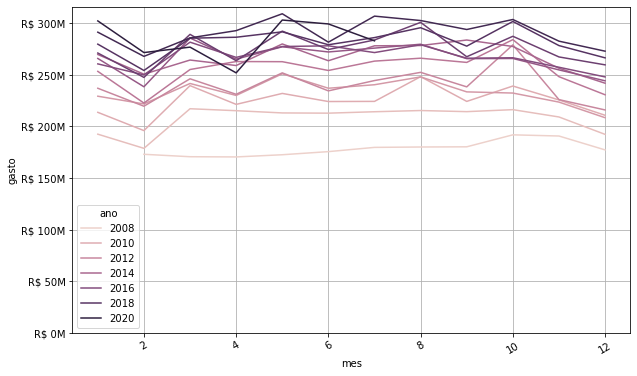

In [65]:
# Agora, vamos utilizar as colunas novas para um plot:

plt.figure(figsize = (10,6))
ax = sns.lineplot(data=mensal_aberto[mensal_aberto.uf == 'São Paulo'], x = "mes", y = "gasto", hue = "ano")

# Customização
plt.xticks(rotation = 30)

plt.ylim(0)
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)

plt.grid()
plt.show()

#### Desafio 01: Melhorar o gráfico ano a ano: - Mudar a palete de cor, colocar um título descritivo, adicionar ticks com o nome de cada mês no eixo x.

<ipython-input-66-b881dd1677a3>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


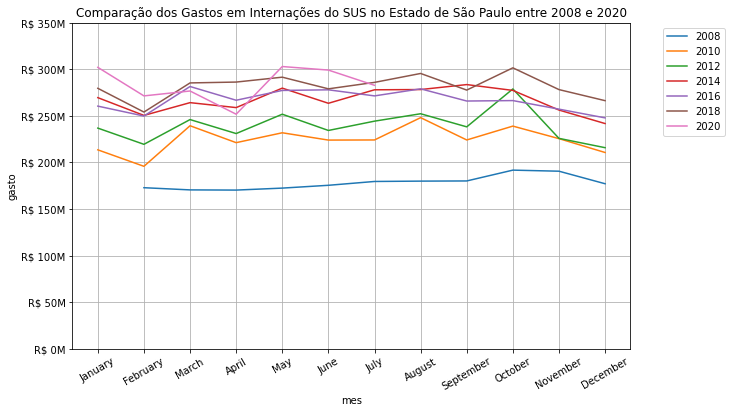

In [66]:
import calendar

# Plot
sns.set_palette("tab10")

plt.figure(figsize = (10,6))
ax = sns.lineplot(data=mensal_aberto[np.logical_and(mensal_aberto.uf == 'São Paulo', (mensal_aberto.ano % 2) == 0) ], x = "mes", y = "gasto", hue = "ano", palette = "tab10")

# Customização X
plt.xticks(rotation = 30)
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset = 0))
labels = calendar.month_name[1:13]
ax.set_xticklabels(labels)


# Customização Y
plt.ylim(0, 350000000)
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)

# Customizações do Plot
plt.title("Comparação dos Gastos em Internações do SUS no Estado de São Paulo entre 2008 e 2020")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

#### Desafio 02: Pegar estados de climas diferentes (por exemplo, norte e sul) e plotar o gráfico de linhas, comparar ambos e compartilhar suas análises.

<ipython-input-67-ae153b3857b5>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plot_count].set_xticklabels(labels)
<ipython-input-67-ae153b3857b5>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plot_count].set_xticklabels(labels)


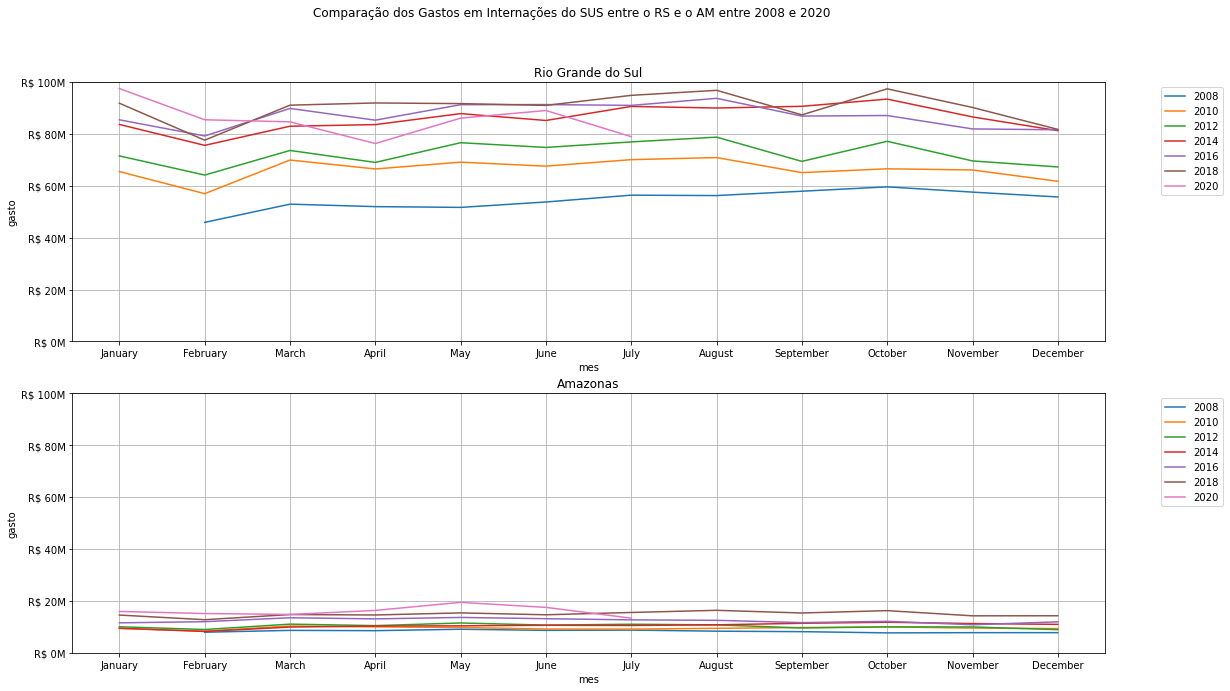

In [67]:
# Plot

fig, axs = plt.subplots(2)
fig.set_size_inches(18.5, 10.5)
fig.suptitle("Comparação dos Gastos em Internações do SUS entre o RS e o AM entre 2008 e 2020")
plot_count = 0
ufs = ["Rio Grande do Sul", "Amazonas"]

for uf in ufs:
    sns.lineplot(data = mensal_aberto[np.logical_and(mensal_aberto.uf == uf,(mensal_aberto.ano % 2) == 0) ],
                 x = "mes", y = "gasto", hue = "ano", palette = "tab10", ax = axs[plot_count])
    
    # Customização X
    axs[plot_count].xaxis.set_major_locator(ticker.IndexLocator(base=1, offset = 0))
    labels = calendar.month_name[1:13]
    axs[plot_count].set_xticklabels(labels)

    # Customização Y
    axs[plot_count].set_ylim(0, 100000000)
    formattery = ticker.FuncFormatter(millions)
    axs[plot_count].yaxis.set_major_formatter(formattery)
    
    axs[plot_count].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[plot_count].grid()
    axs[plot_count].set_title(f'{uf}')
    plot_count =+ 1
    


# Customizações do Plot
plt.show()

Como os estados gastam valores muito diferentes, irei dar um zoom nos valores do estado do Amazonas para poder verificar o comportamento da linha com mais precisão.

<ipython-input-68-8d1529e694ab>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plot_count].set_xticklabels(labels)
<ipython-input-68-8d1529e694ab>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plot_count].set_xticklabels(labels)


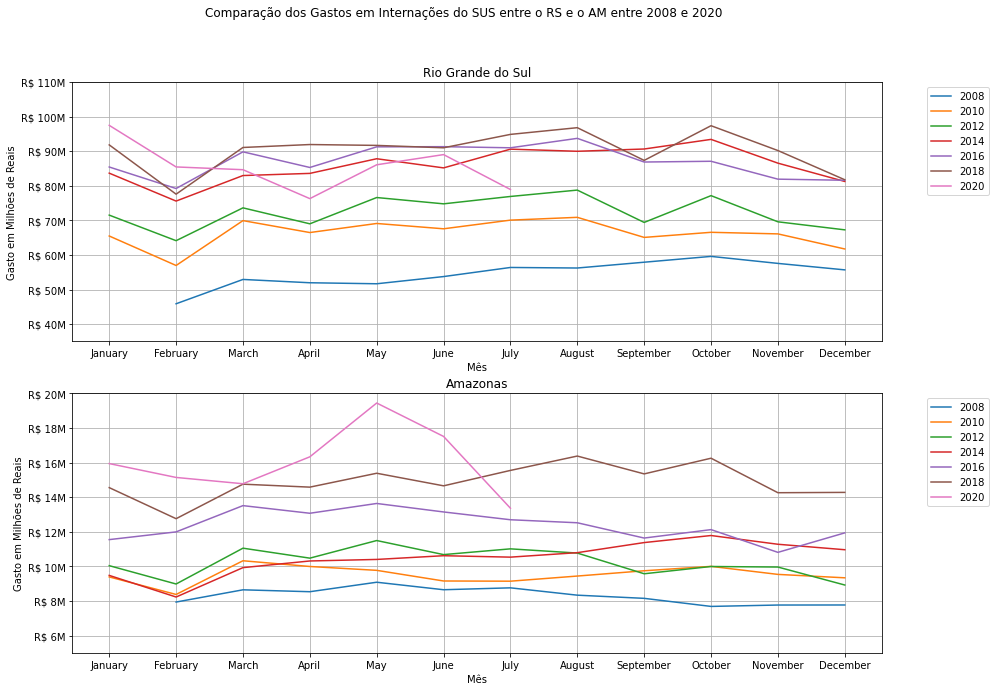

In [68]:
# Plot

fig, axs = plt.subplots(2)
fig.set_size_inches(14.5, 10.5)
fig.suptitle("Comparação dos Gastos em Internações do SUS entre o RS e o AM entre 2008 e 2020")
plot_count = 0
ufs = ["Rio Grande do Sul", "Amazonas"]

for uf in ufs:
    sns.lineplot(data = mensal_aberto[np.logical_and(mensal_aberto.uf == uf,(mensal_aberto.ano % 2) == 0) ],
                 x = "mes", y = "gasto", hue = "ano", palette = "tab10", ax = axs[plot_count])
    
    # Customização X
    axs[plot_count].xaxis.set_major_locator(ticker.IndexLocator(base=1, offset = 0))
    labels = calendar.month_name[1:13]
    axs[plot_count].set_xticklabels(labels)
    axs[plot_count].set_xlabel("Mês")

    # Customização Y
    axs[plot_count].set_ylim(35000000, 110000000)
    if plot_count == 1:
        axs[plot_count].set_ylim(5000000, 20000000)
    axs[plot_count].set_ylabel("Gasto em Milhões de Reais")
    formattery = ticker.FuncFormatter(millions)
    axs[plot_count].yaxis.set_major_formatter(formattery)
    
    axs[plot_count].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[plot_count].grid(which = 'both')
    axs[plot_count].set_title(f'{uf}')
    plot_count =+ 1
    


# Customizações do Plot
plt.show()

Podemos identificar algumas coisas nos gráficos:

* A subida expressiva no ano de 2020 no estado do Amazonas. Foram noticiadas diversas vezes como o estado reagiu ao COVID-19 e o gráfico dos custos em internação demonstra bastante isso;
* Existe sempre uma queda nos gráficos dos dois estados no mês de fevereiro (possívelmente pelo menor número de dias) e é muito comum ela acontecer novamente em Abril (mês após o Carnaval);
* É possível verificar subidas mais bruscas no mês de Outrubro no Rio Grande do Sul;
* No geral, os gráficos tem um comportamento meio parecido, apesar das diferenças climáticas.

In [69]:
dias_por_mes = {
    1 : 31,
    2 : 28,
    3 : 31,
    4 : 30,
    5 : 31,
    6: 30,
    7 : 31,
    8 : 31,
    9 : 30,
    10 : 31,
    11 : 30,
    12: 31
}

# Para resolver o problema da diferença no número de dias por mês, iremos criar uma coluna com o gasto por dia em cada mês,
# utilizando o dicionário criado acima. 

mensal_aberto['gasto_por_dia'] = mensal_aberto.gasto / mensal_aberto.mes.map(dias_por_mes)

In [70]:
mensal_aberto.head()

,dia_mes_ano,uf,gasto,mes,ano,gasto_por_dia
0,2008-02-01,São Paulo,172834914.73,2,2008,6172675.53
1,2008-03-01,São Paulo,170481849.56,3,2008,5499414.50
2,2008-04-01,São Paulo,170278285.95,4,2008,5675942.86
3,2008-05-01,São Paulo,172402180.59,5,2008,5561360.66
4,2008-06-01,São Paulo,175416595.83,6,2008,5847219.86


Refazendo o plot comparativo entre os estados:

<ipython-input-71-95e18cfcf310>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plot_count].set_xticklabels(labels)
<ipython-input-71-95e18cfcf310>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plot_count].set_xticklabels(labels)


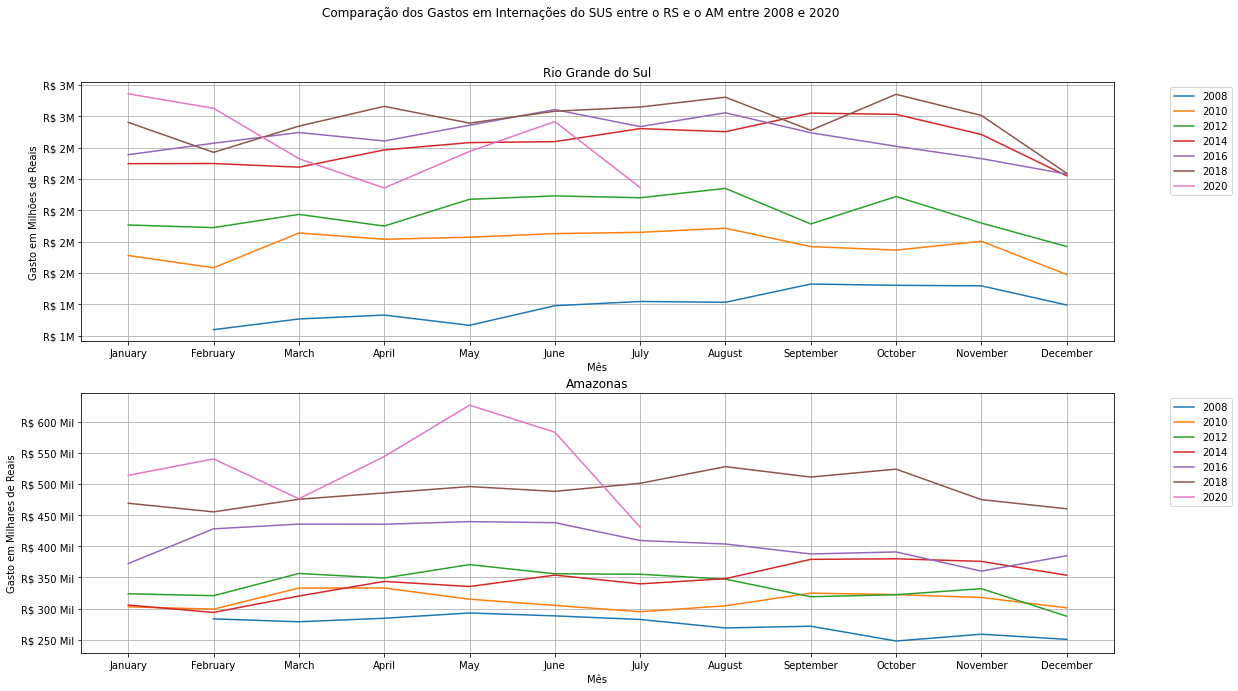

In [71]:
# Plot

fig, axs = plt.subplots(2)
fig.set_size_inches(18.5, 10.5)
fig.suptitle("Comparação dos Gastos em Internações do SUS entre o RS e o AM entre 2008 e 2020")
plot_count = 0
ufs = ["Rio Grande do Sul", "Amazonas"]

# Função helper
def thousands(x, pos):
    return f'R$ {int(x/1000)} Mil'

for uf in ufs:
    sns.lineplot(data = mensal_aberto[np.logical_and(mensal_aberto.uf == uf,(mensal_aberto.ano % 2) == 0) ],
                 x = "mes", y = "gasto_por_dia", hue = "ano", palette = "tab10", ax = axs[plot_count])
    
    # Customização X
    axs[plot_count].xaxis.set_major_locator(ticker.IndexLocator(base=1, offset = 0))
    labels = calendar.month_name[1:13]
    axs[plot_count].set_xticklabels(labels)
    axs[plot_count].set_xlabel("Mês")

    # Customização Y
#     axs[plot_count].set_ylim(35000000, 110000000)

    axs[plot_count].set_ylabel("Gasto em Milhões de Reais")
    formattery = ticker.FuncFormatter(millions)
    axs[plot_count].yaxis.set_major_formatter(formattery)
    if plot_count == 1:
        axs[plot_count].set_ylabel("Gasto em Milhares de Reais")
        formattery = ticker.FuncFormatter(thousands)
        axs[plot_count].yaxis.set_major_formatter(formattery)
    
    axs[plot_count].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[plot_count].grid(which = 'both')
    axs[plot_count].set_title(f'{uf}')
    plot_count =+ 1
    


# Customizações do Plot
plt.show()

<ipython-input-76-9d853654d553>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plot_count].set_xticklabels(labels, rotation = 90)
<ipython-input-76-9d853654d553>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plot_count].set_xticklabels(labels, rotation = 90)


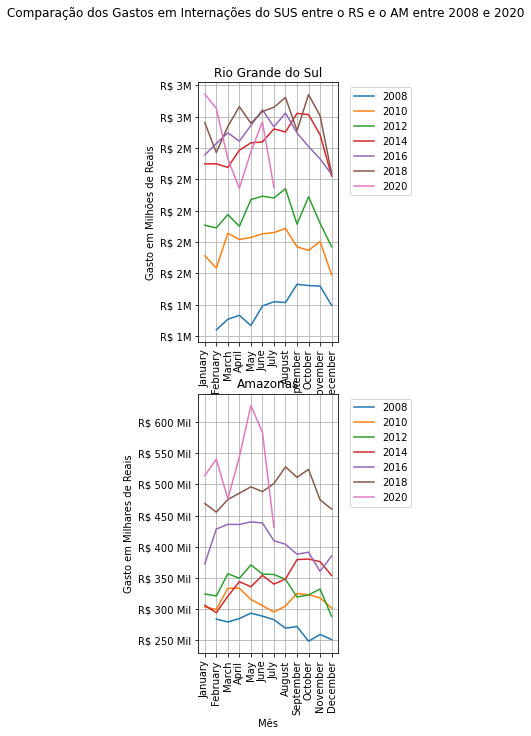

In [76]:
# Plot

fig, axs = plt.subplots(2)
fig.set_size_inches(2.5, 10.5)
fig.suptitle("Comparação dos Gastos em Internações do SUS entre o RS e o AM entre 2008 e 2020")
plot_count = 0
ufs = ["Rio Grande do Sul", "Amazonas"]

# Função helper
def thousands(x, pos):
    return f'R$ {int(x/1000)} Mil'

for uf in ufs:
    sns.lineplot(data = mensal_aberto[np.logical_and(mensal_aberto.uf == uf,(mensal_aberto.ano % 2) == 0) ],
                 x = "mes", y = "gasto_por_dia", hue = "ano", palette = "tab10", ax = axs[plot_count])
    
    # Customização X
    axs[plot_count].xaxis.set_major_locator(ticker.IndexLocator(base=1, offset = 0))
    labels = calendar.month_name[1:13]
    axs[plot_count].set_xticklabels(labels, rotation = 90)
    axs[plot_count].set_xlabel("Mês")

    # Customização Y
#     axs[plot_count].set_ylim(35000000, 110000000)

    axs[plot_count].set_ylabel("Gasto em Milhões de Reais")
    formattery = ticker.FuncFormatter(millions)
    axs[plot_count].yaxis.set_major_formatter(formattery)
    if plot_count == 1:
        axs[plot_count].set_ylabel("Gasto em Milhares de Reais")
        formattery = ticker.FuncFormatter(thousands)
        axs[plot_count].yaxis.set_major_formatter(formattery)
    
    axs[plot_count].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[plot_count].grid(which = 'both')
    axs[plot_count].set_title(f'{uf}')
    plot_count =+ 1
    


# Customizações do Plot
plt.show()

Perceba que, com exceções de um ou outro ano, as linhas tem um comportamento de queda. Normalmente ocorre um aumento nos gastos próximo à metade do ano no Rio Grande do Sul, enquanto no Amazonas isso ocorre antes. 

## AULA 6 - AGRUPANDO DADOS E ANALISANDO POR CATEGORIA

Para essa aula, utilizaremos o groupby para calcular o gasto anual de algum estado (nesse caso, São Paulo).

In [74]:
estado_a_analisar = mensal_aberto.query("uf=='São Paulo'")
estado_a_analisar.head()

,dia_mes_ano,uf,gasto,mes,ano,gasto_por_dia
0,2008-02-01,São Paulo,172834914.73,2,2008,6172675.53
1,2008-03-01,São Paulo,170481849.56,3,2008,5499414.50
2,2008-04-01,São Paulo,170278285.95,4,2008,5675942.86
3,2008-05-01,São Paulo,172402180.59,5,2008,5561360.66
4,2008-06-01,São Paulo,175416595.83,6,2008,5847219.86


In [77]:
estado_a_analisar.groupby("ano").sum()

,gasto,mes,gasto_por_dia
ano,,,
2008,1960230442.26,77,64600828.91
2009,2489030484.83,78,81823449.01
2010,2696622949.86,78,88626495.26
2011,2794549339.77,78,91905424.14
2012,2873973262.98,78,94466122.27
2013,3062805404.03,78,100672714.25
2014,3200546458.40,78,105250700.44
2015,3187853942.41,78,104793836.89
2016,3200665738.14,78,105258331.99


Note que o df.sum() acabou somando também os meses e o gasto diário. Podemos apenas ignorar essas colunas para o plot a seguir.

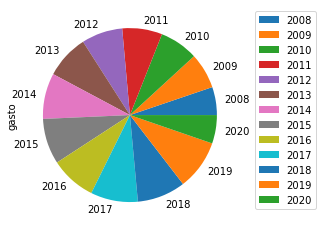

In [82]:
estado_a_analisar.groupby("ano").sum().plot(kind = 'pie', y = "gasto")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

O gráfico de pizza não ajuda muito nesse caso... Como o valor dos gastos anuais estão próximos, parece que todos são iguais e fica difícil analisar e comparar os anos.

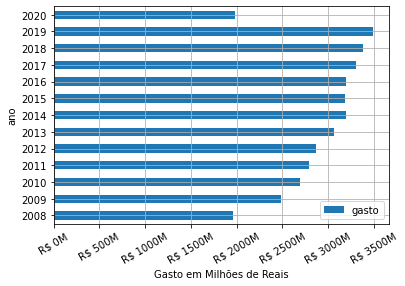

In [88]:
ax = estado_a_analisar.groupby("ano").sum().plot(kind = 'barh', y = "gasto")


ax.set_xlabel("Gasto em Milhões de Reais")
formatterx = ticker.FuncFormatter(millions)
ax.xaxis.set_major_formatter(formatterx)
plt.xticks(rotation = 30)
plt.grid()

Com o gráfico de barras, podemos identificar que existe, de modo geral, um crescimento anual nos gastos, esperado pelo aumento e envelhecimento da população. Pode-se perceber que no ano de 2008, os dados apontam para um valor bem menor do que nos outros anos.

Isso se deve a falta de dados sobre janeiro desse ano, além de ser o ano em que os dados começaram a ser guardados corretamente.

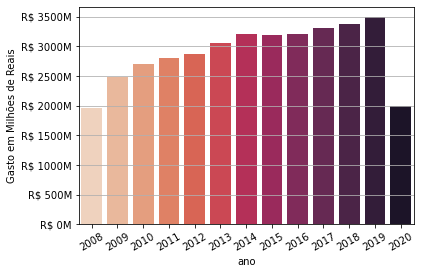

In [96]:
ax = sns.barplot(data = estado_a_analisar.groupby("ano").sum(), x = estado_a_analisar.groupby("ano").sum().index,
            y = "gasto", palette = sns.color_palette("rocket_r", 13))

ax.set_ylabel("Gasto em Milhões de Reais")
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)

plt.xticks(rotation = 30)
plt.grid(axis = 'y')

Note que as cores no gráfico acima não adicionamm nenhuma informação nem reforçam nada, uma vez que elas estão mudando de acordo com os anos. No desafio abaixo, iremos utilizar as cores para reforçar as diferenças entre os tamanhos das barras, deixando-as mais escuras com o aumento do valor de Y. 

#### Desafio 01: Reordenar as cores pelo valor do eixo y.

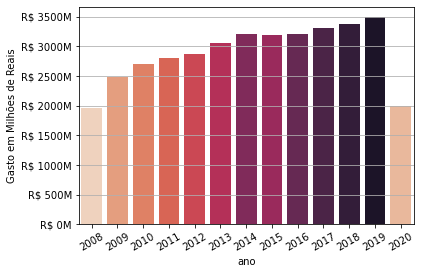

In [111]:
ax = sns.barplot(data = estado_a_analisar.groupby("ano").sum(), x = estado_a_analisar.groupby("ano").sum().index,
            y = "gasto", palette = sns.color_palette("rocket_r", 13), hue = "gasto", dodge = False)

ax.set_ylabel("Gasto em Milhões de Reais")
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)
ax.legend_.remove()


plt.xticks(rotation = 30)
plt.grid(axis = 'y')

Agora, vamos comparar os valores dos gastos anuais entre diferentes estados do Brasil:

In [120]:
estados = ["Minas Gerais", "São Paulo", "Pernambuco"]
por_ano_estados = mensal_aberto.query("uf in @estados").groupby(["uf","ano"]).sum()[["gasto"]].reset_index()
por_ano_estados.head(10)

,uf,ano,gasto
0,Minas Gerais,2008,894346731.42
1,Minas Gerais,2009,1149141349.15
2,Minas Gerais,2010,1217493124.37
3,Minas Gerais,2011,1315021864.36
4,Minas Gerais,2012,1408354148.98
5,Minas Gerais,2013,1514838584.90
6,Minas Gerais,2014,1646223633.83
7,Minas Gerais,2015,1660807530.65
8,Minas Gerais,2016,1639965675.03
9,Minas Gerais,2017,1727889546.97


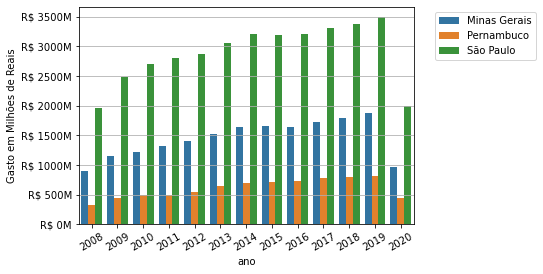

In [126]:
ax = sns.barplot(data = por_ano_estados, x = 'ano', y = "gasto", hue='uf')

ax.set_ylabel("Gasto em Milhões de Reais")
formattery = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formattery)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation = 30)
plt.grid(axis = 'y')

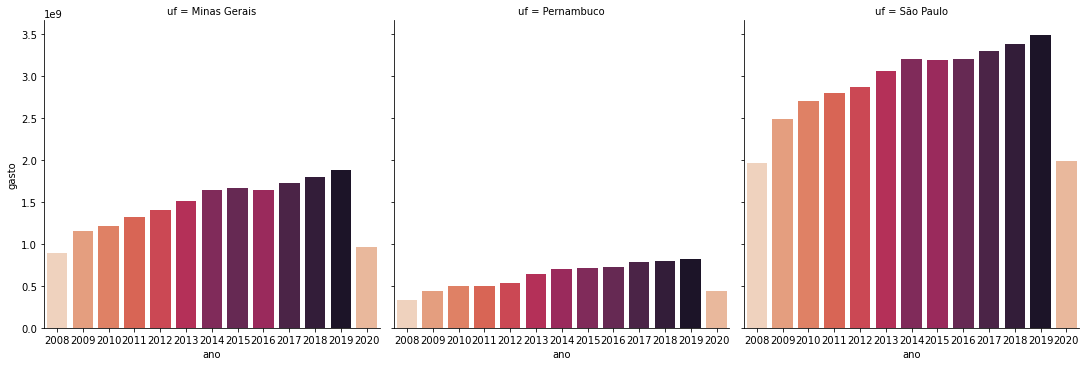

In [134]:
ax = sns.catplot(data = por_ano_estados, x = "ano", y= "gasto", kind = "bar", col = "uf",
                     palette = sns.color_palette("rocket_r", 13), hue = "gasto", dodge = False, legend = False)